### Importante bibliotecas e base de dados

In [2]:
# bibliotecas padrões
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# bibliotecas para NLP
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# bibliotecas para modelagem
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate

dados = pd.read_csv('final_dados_feedbacks.csv')

In [3]:
dados[['Data', 'Feedback', 'Sentimento']].head(4)

,Data,Feedback,Sentimento
0,28/03/2020,Não,positivo
1,29/03/2020,"Eu indicaria ele abordar um tema novo, não só ...",negativo
2,04/04/2020,As histórias que ele conta e a maneira como ab...,positivo
3,04/04/2020,"Adorei as coisas que ele falou, foi muuuito le...",positivo


In [4]:
dados.shape

(1180, 4)

## Limpeza do Texto

#### Retirando perguntas do Dataframe

Existem algumas perguntas no Dataframe que é sobre Autoavaliação, como queremos um modelo que classifica apenas os feedbacks para os palestrantes e para o CEO vamos retirar os comentários de Autoavaliação.

In [5]:
# Perguntas do dataframe
#dados.Perguntas.value_counts()

In [6]:
# Pergunta errada, verificando se vale a pena deixar no dataframe
dados[dados['Perguntas'] == 'Sobre as atividades do VimVer. O quanto você recomendaria para outro aluno? (Só coloque ZERO se você não participou)'].head(3)

,Data,Feedback,Perguntas,Sentimento
32,18/04/2020,Foi muito boa! Adorei e me deu várias ideias.,Sobre as atividades do VimVer. O quanto você r...,positivo
291,04/04/2020,Sem comentários,Sobre as atividades do VimVer. O quanto você r...,positivo
292,04/04/2020,Foi muito boa! Ele tinha mt dominio do assunto...,Sobre as atividades do VimVer. O quanto você r...,positivo


In [7]:
# Pergunta errada, verificando se vale a pena deixar no dataframe
dados[dados['Perguntas'] == 'Simplismente demaisss']

,Data,Feedback,Perguntas,Sentimento
439,30/05/2020,Simplismente demaisss,Simplismente demaisss,positivo


#### Quais Perguntas retirar do Dataframe?

1. Escreva uma autoavaliação da sua EXECUÇÃO na etapa de PROTOTIPAGEM (VimVer)
2. Escreva uma autoavaliação da sua execução na etapa de MAPEAMENTO (VimVer). OBS: Etapa iniciada no penúltimo encontro.
3. Escreva uma autoavaliação da sua EXECUÇÃO na etapa de IDEAÇÃO (VimVer). OBS: Etapa iniciada no penúltimo encontro.
4. Escreva uma autoavaliação da sua EXECUÇÃO na etapa de EXPERIMENTAÇÃO (VimVer)

In [8]:
# Eliminando perguntas que não fazem sentido do dataframe
dados = dados.loc[(dados['Perguntas'] != 'Escreva uma autoavaliação da sua EXECUÇÃO na etapa de PROTOTIPAGEM (VimVer)') &
         (dados['Perguntas'] != 'Escreva uma autoavaliação da sua execução na etapa de MAPEAMENTO (VimVer). OBS: Etapa iniciada no penúltimo encontro.') &
         (dados['Perguntas'] != 'Escreva uma autoavaliação da sua EXECUÇÃO na etapa de IDEAÇÃO (VimVer). OBS: Etapa iniciada no penúltimo encontro.') &
         (dados['Perguntas'] != 'Escreva uma autoavaliação da sua EXECUÇÃO na etapa de EXPERIMENTAÇÃO (VimVer)')]

In [9]:
dados.shape

(1007, 4)

#### Spell Checker

In [10]:
#from spellchecker import SpellChecker
#def Corretor(feedback):
#    spell = SpellChecker(language='pt')
#    palavras = []
#    for w in feedback.split():
#        palavras.append(spell.correction(w))
#    return (" ".join(palavras))

#dados['Feedback'] = dados['Feedback'].apply(lambda x: Corretor(x))

#### Transformando tudo em minúsculo e retirando acentos

Acentos e letras em maiúsculo podem atrapalhar o modelo a identificar padrão, já que "Não", "Nao", "não" e "nao" tem o mesmo significado, mas acabam sendo tratados como palavras diferentes pelo modelo.

In [11]:
dados.Feedback = dados.Feedback.str.lower()

In [12]:
dados['Feedback'] = dados['Feedback'].apply(lambda x: unidecode(x))

In [13]:
dados[['Data', 'Feedback', 'Sentimento']].head(4)

,Data,Feedback,Sentimento
0,28/03/2020,nao,positivo
1,29/03/2020,"eu indicaria ele abordar um tema novo, nao so ...",negativo
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo
3,04/04/2020,"adorei as coisas que ele falou, foi muuuito le...",positivo


#### Removendo pontuações

Pontuações também não agregam muito valor para o modelo pois um "." ou "," não tem muito significado para identificar um sentimento.

In [14]:
def RemovePunctuation(feedback):
    feedback = re.sub(r"[-|0-9]", "", feedback).lower()
    feedback = re.sub(r'[-./?!,":;()\']', ' ', feedback).lower()
    return (feedback)

In [15]:
lista_feedback = []
lista_feedback = [RemovePunctuation(feedback) for feedback in dados.Feedback]

In [16]:
dados.Feedback = lista_feedback

#### Removendo Espaçamentos duplos

In [17]:
dados['Feedback'] = dados['Feedback'].apply(lambda x: x.strip())

In [18]:
dados['Feedback'] = dados['Feedback'].apply(lambda x: x.replace("  ", " "))

In [19]:
dados[['Data', 'Feedback', 'Sentimento']].head(4)

,Data,Feedback,Sentimento
0,28/03/2020,nao,positivo
1,29/03/2020,eu indicaria ele abordar um tema novo nao so o...,negativo
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo
3,04/04/2020,adorei as coisas que ele falou foi muuuito leg...,positivo


In [20]:
dados.drop_duplicates(subset=['Feedback'], inplace=True)
dados.shape

(784, 4)

## EDA

#### Criando coluna de contagem de palavras

In [21]:
dados['Contagem_palavras'] = dados['Feedback'].apply(lambda x: len(str(x).split(" ")))
dados[['Data', 'Feedback', 'Sentimento', 'Contagem_palavras']].head(4)

,Data,Feedback,Sentimento,Contagem_palavras
0,28/03/2020,nao,positivo,1
1,29/03/2020,eu indicaria ele abordar um tema novo nao so o...,negativo,24
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo,12
3,04/04/2020,adorei as coisas que ele falou foi muuuito leg...,positivo,12


In [22]:
graph = dados[['Sentimento', 'Contagem_palavras']].groupby('Sentimento').mean().reset_index()

In [23]:
graph.Sentimento

0    negativo
1    positivo
Name: Sentimento, dtype: object

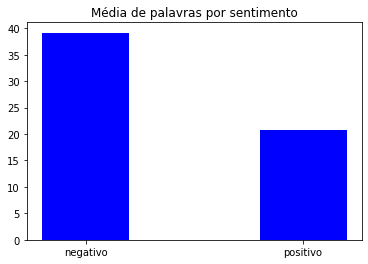

In [24]:
plt.bar(graph.Sentimento, graph.Contagem_palavras, width=0.4, color='blue')
plt.title('Média de palavras por sentimento')
plt.show()

Na média os comentários negativos tem mais palavras, seguido por positivos e depois neutros.

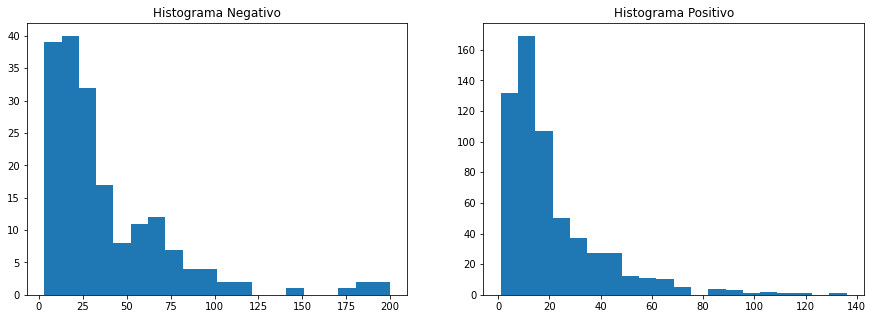

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.hist(dados[dados['Sentimento'] == 'negativo']['Contagem_palavras'], 20)
ax1.set_title('Histograma Negativo')

ax2.hist(dados[dados['Sentimento'] == 'positivo']['Contagem_palavras'], 20)
ax2.set_title('Histograma Positivo')

plt.show()

#### Criando coluna de contagem de stopwords

In [26]:
# importando stopwords das libs spacy e nltk
stopwords = stopwords.words('portuguese')
stopwords_spacy = STOP_WORDS

In [27]:
# criando apenas uma lista de stopwords
for word in stopwords_spacy:
    if not word in stopwords:
        stopwords.append(word)
        
stopwords.append('nao')
stopwords = set(stopwords)

In [28]:
dados['Contagem_stopwords'] = dados['Feedback'].apply(lambda x: len([x for x in x.split() if x in stopwords]))
dados[['Data', 'Feedback', 'Sentimento', 'Contagem_palavras', 'Contagem_stopwords']].head(4)

,Data,Feedback,Sentimento,Contagem_palavras,Contagem_stopwords
0,28/03/2020,nao,positivo,1,1
1,29/03/2020,eu indicaria ele abordar um tema novo nao so o...,negativo,24,14
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo,12,6
3,04/04/2020,adorei as coisas que ele falou foi muuuito leg...,positivo,12,5


In [234]:
graph = dados[['Sentimento', 'Contagem_stopwords']].groupby('Sentimento').mean().reset_index()

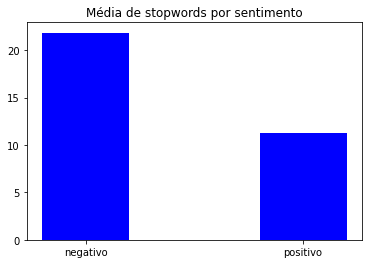

In [235]:
plt.bar(graph.Sentimento, graph.Contagem_stopwords, width=0.4, color='blue')
plt.title('Média de stopwords por sentimento')
plt.show()

Na média os comentários negativos tem mais stopwords, seguido por positivos e depois neutros.

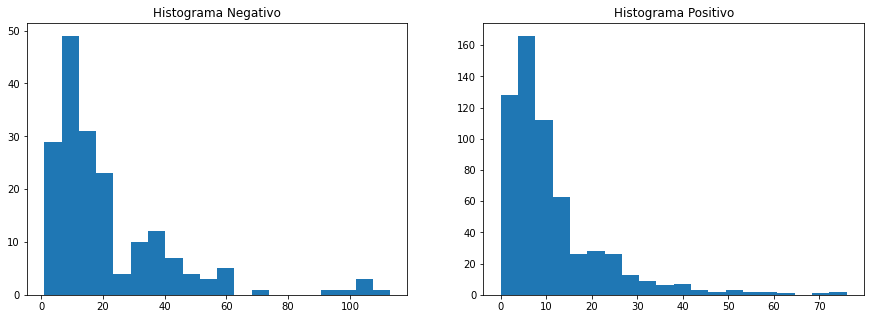

In [236]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.hist(dados[dados['Sentimento'] == 'negativo']['Contagem_stopwords'], 20)
ax1.set_title('Histograma Negativo')

ax2.hist(dados[dados['Sentimento'] == 'positivo']['Contagem_stopwords'], 20)
ax2.set_title('Histograma Positivo')

plt.show()

#### Calculando frequência de palavras

In [237]:
nlp = word_tokenize

In [238]:
# separando textos positivos, negativos e neutros
texto_positivo = str()
for feedback in dados[dados['Sentimento'] == 'positivo']['Feedback']:
    texto_positivo += feedback
    
texto_neutro = str()
for feedback in dados[dados['Sentimento'] == 'neutro']['Feedback']:
    texto_neutro += feedback
    
texto_negativo = str()
for feedback in dados[dados['Sentimento'] == 'negativo']['Feedback']:
    texto_negativo += feedback   

In [239]:
# transformando palavras e um dataframe com as colunas termo e frequência
dados_positivo = pd.DataFrame.from_dict(FreqDist(nlp(texto_positivo)), orient='index')
dados_positivo.columns = ['Frequencia']
dados_positivo.index.name = 'Termo'
dados_positivo = dados_positivo.sort_values('Frequencia', ascending=False).reset_index()

dados_negativo = pd.DataFrame.from_dict(FreqDist(nlp(texto_negativo)), orient='index')
dados_negativo.columns = ['Frequencia']
dados_negativo.index.name = 'Termo'
dados_negativo = dados_negativo.sort_values('Frequencia', ascending=False).reset_index()

##### Palavras mais comuns

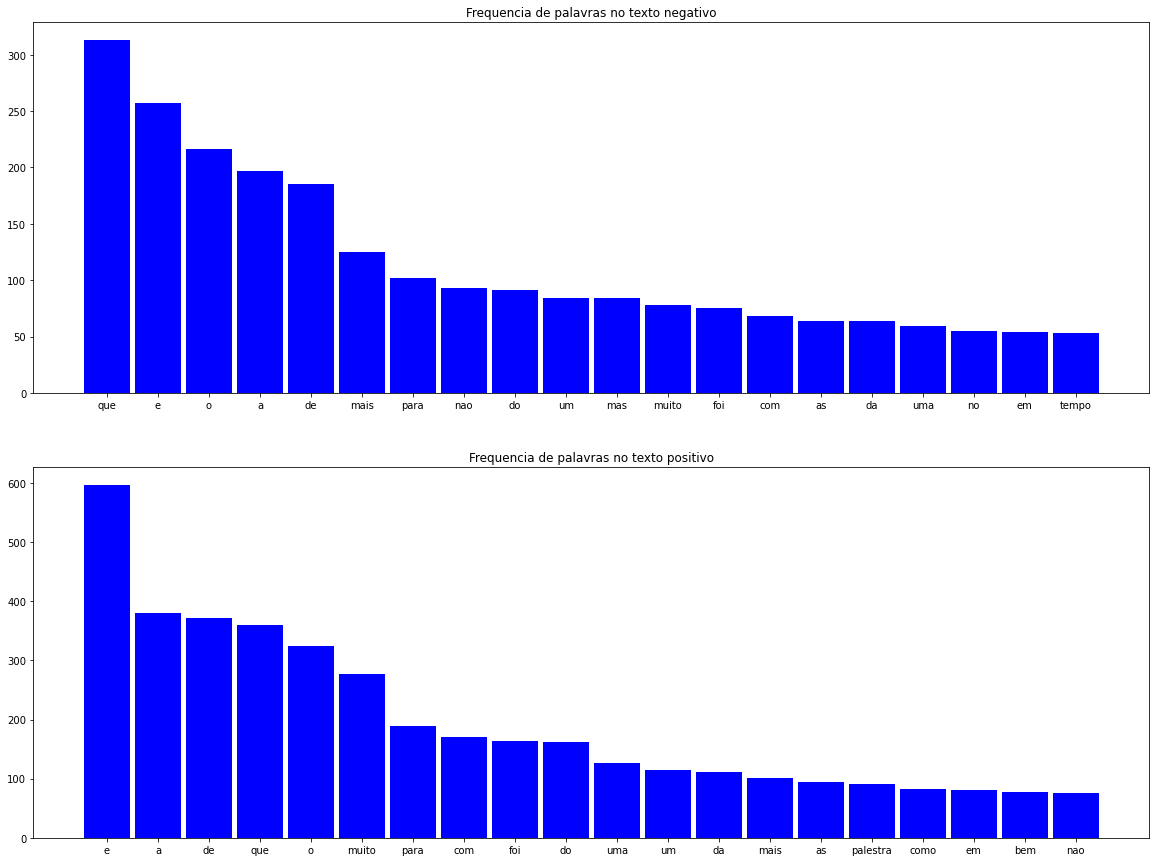

In [240]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

ax1.bar(dados_negativo.head(20)['Termo'], dados_negativo.head(20)['Frequencia'], width=0.9, color='blue')
ax1.set_title('Frequencia de palavras no texto negativo')
ax2.bar(dados_positivo.head(20)['Termo'], dados_positivo.head(20)['Frequencia'], width=0.9, color='blue')
ax2.set_title('Frequencia de palavras no texto positivo')

plt.show()

#### Palavras mais raras

In [241]:
dados_positivo = dados_positivo.sort_values('Frequencia', ascending=True).reset_index()
dados_negativo = dados_negativo.sort_values('Frequencia', ascending=True).reset_index()

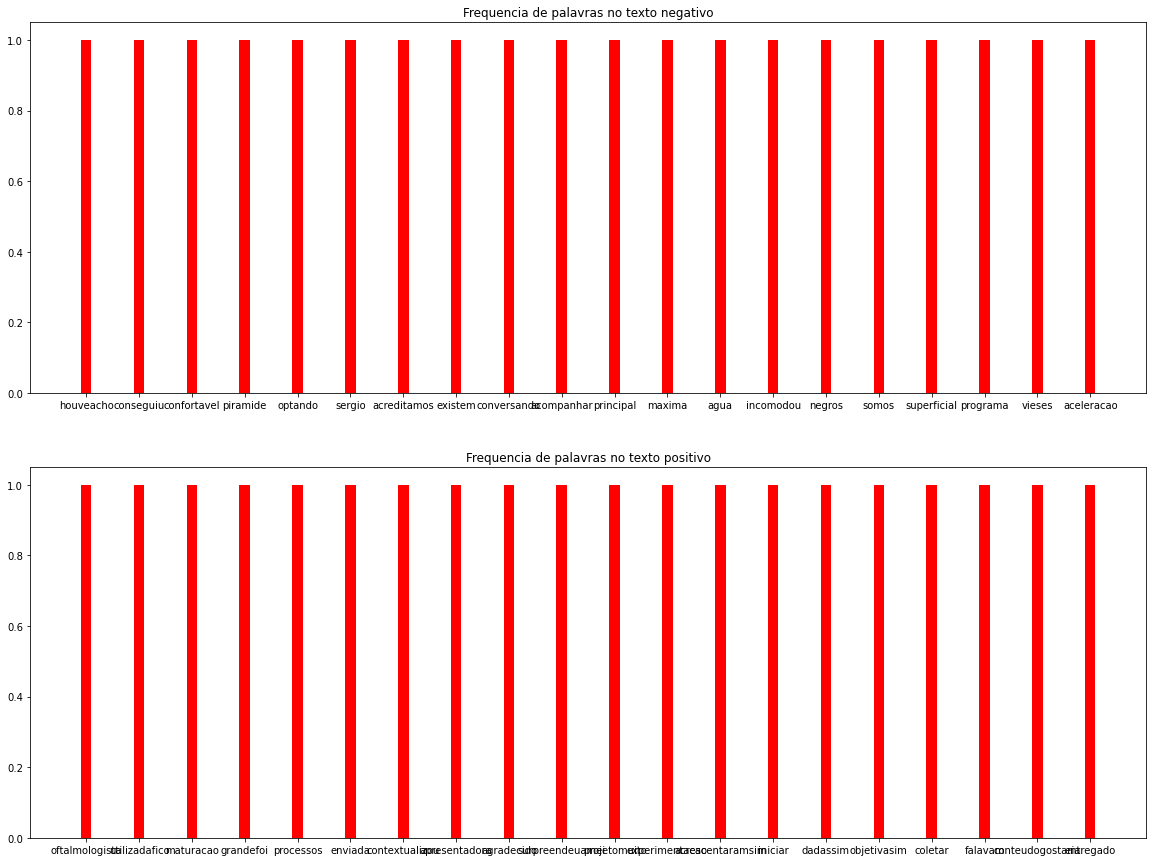

In [242]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

ax1.bar(dados_negativo.head(20)['Termo'], dados_negativo.head(20)['Frequencia'], width=0.2, color='red')
ax1.set_title('Frequencia de palavras no texto negativo')
ax2.bar(dados_positivo.head(20)['Termo'], dados_positivo.head(20)['Frequencia'], width=0.2, color='red')
ax2.set_title('Frequencia de palavras no texto positivo')

plt.show()

## Pré-processamento

#### Removendo stopwords

In [243]:
def RemoveStopWords(feedback):
    palavras = [i for i in feedback.split() if not i in stopwords]
    return (" ".join(palavras))

lista_feedback = []
lista_feedback = [RemoveStopWords(feedback) for feedback in dados.Feedback]

dados['Feedback_stop'] = lista_feedback

#### Tag de Negação

Acrescenta uma tag _NEG encontrada após um 'não'. Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
Exemplos:
- Eu gosto de cachorros, positivo.
- Eu não gosto de cachorros, negativo.

In [244]:
def marque_negacao(feedback):
    negacoes = ['nao','not']
    negacao_detectada = False
    resultado = []
    palavras = feedback.split()
    for p in palavras:
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

#### Stemming

In [245]:
def Stemming(feedback):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in feedback.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

#### Lematization

In [246]:
lemmatizer = WordNetLemmatizer()
def Lemmatization(feedback):
  palavras = []
  for w in feedback.split():
    palavras.append(lemmatizer.lemmatize(w))
  return (" ".join(palavras))

#### Pos_tagging

In [247]:
import spacy
nlp = spacy.load('pt_core_news_sm')

In [248]:
def get_postags(row):
    
    row = nlp(row)
    new_row = []

    for token in row:
        palavra = token.text + "_" + token.pos_
        new_row.append(palavra)
    
    return (" ".join(new_row))

## Blanceado Classes

Como temos dados desbalanceados, com comentários positivos muitos maiores que negativos, precisamos balancear
as classes para não enviesar o modelo.

In [249]:
dados.Sentimento.value_counts()

positivo    600
negativo    184
Name: Sentimento, dtype: int64

In [250]:
sentimento=['Negativo', 'Positivo']
le = LabelEncoder()
le.fit(dados['Sentimento'])
target_encoded = le.transform(dados['Sentimento'])

In [251]:
dados['target_encoded'] = target_encoded

In [252]:
dados.target_encoded.value_counts()

1    600
0    184
Name: target_encoded, dtype: int64

In [253]:
count_class_1, count_class_0 = dados.target_encoded.value_counts()

In [254]:
# Divide by class
dados_class_0 = dados[dados['target_encoded'] == 0]
dados_class_1 = dados[dados['target_encoded'] == 1]

Random under-sampling:
1    184
0    184
Name: target_encoded, dtype: int64


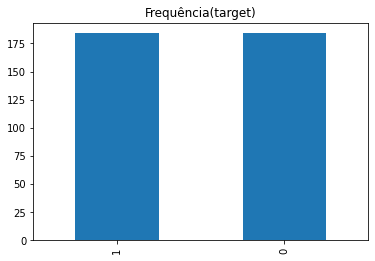

In [255]:
dados_class_0_under = dados_class_0.sample(count_class_0, random_state=42)
dados_class_1_under = dados_class_1.sample(count_class_0, random_state=42)
dados = pd.concat([dados_class_0_under, dados_class_1_under], axis=0)

print('Random under-sampling:')
print(dados.target_encoded.value_counts())

dados.target_encoded.value_counts().plot(kind='bar', title='Frequência(target)');

In [256]:
target_encoded = dados['target_encoded']

## Validando Modelos

Definiremos algumas funções para validar o modelo assim como as métricas ideais para esse caso.

Usaremos o classification report para ter uma visão mais geral da performance, porém a principal métrica será o F1-Score pois nossos dados são desbalanceados.

#### Bag of Words com TFIDF e Count Vectorizer

Tokens: Um token é cada elemento dentro de um texto, pode ser uma palavra, sentence, pontuações ou qualquer outro elemento, isso depende da necessidade do modelo.

Bag of Words é um técnica para Processamento de Lingaguem Natural, como o próprio nome já diz, transforma os textos em um "Sacola de Palavra", onde cada linha são os comentários e cada coluna é seu respectivo token e os valores são uma representação númerica dos tokens.

Para fazer essas representação númerica utilizaremos duas técnicas diferentes para testar qual tem melhor pontuação.

Count Vectorizer: Converte os textos em uma matrix de contagem de tokens, ou seja, quantas vezes aquele token aparece no texto.

TF-IDF: Converte os textos em uma matrix TFIDF.

TF significa Term-frequency e TF-IDF significa Term-frequency times inverse document-frenquecy, a ideia é diminuir o impacto de termos que aparecem frequentemente no texto mas não são muito informativos.

<img src="tfidf-formula.png">

In [257]:
# função para transformar o texto em Matrix Count e TFIDF
def bow(feedbacks):
    bag_of_words_transformer = TfidfVectorizer()
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_tfidf = pd.DataFrame(mx, columns=terms, index=feedbacks)

    bag_of_words_transformer = CountVectorizer()
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_count = pd.DataFrame(mx, columns=terms, index=feedbacks)
    
    return (dados_tfidf, dados_count)

#### Primeiro Modelo (TFIDF E COUNTVECTORIZER)

#### Métricas

Recall: Recall é intuitivamente a habilidade do modelo de achar todas as amostras "Positivas" (de todas positivas quantas o modelo acertou?).

Precision: Precision é intuitivamente a habilidade do modelo não classificar como "Positivo" algo que é "Negativo (de todas classificadas como positivo, quantas realmente eram positivas?).

<img src="precision-recall-formula.png">

F1-Score: F1-Score é a média harmônica ponderada entre Precision e Recall

<img src="f1-score-formula.png">

In [258]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [259]:
dados_tfidf, dados_count = bow(dados.Feedback)

In [260]:
svc = SVC(random_state=42)

In [261]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.806946,0.806934,0.807357,0.809098,0.807220
COUNT,0.746273,0.746247,0.747673,0.752082,0.747501


#### Segundo Modelo (Coluna de Contagem de Palavras)

In [262]:
dados_tfidf, dados_count = bow(dados.Feedback)
dados_tfidf['Contagem_palavras'] = list(dados['Contagem_palavras'])
dados_count['Contagem_palavras'] = list(dados['Contagem_palavras'])

In [263]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dados_tfidf = scaler.fit_transform(dados_tfidf)
dados_count = scaler.fit_transform(dados_count)

In [264]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.681713,0.681796,0.684610,0.691161,0.684783
COUNT,0.651266,0.651299,0.657733,0.670019,0.657756


#### Terceiro Modelo (Coluna de Contagem de Stopwords)

In [265]:
dados_tfidf, dados_count = bow(dados.Feedback)
dados_tfidf['Contagem_stopwords'] = list(dados['Contagem_stopwords'])
dados_count['Contagem_stopwords'] = list(dados['Contagem_stopwords'])

In [266]:
scaler = StandardScaler()
dados_tfidf = scaler.fit_transform(dados_tfidf)
dados_count = scaler.fit_transform(dados_count)

In [267]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.681713,0.681796,0.684610,0.691161,0.684783
COUNT,0.651266,0.651299,0.657733,0.670019,0.657756


#### Quarto Modelo (Sem stopwords)

In [268]:
target_encoded = dados[dados.Feedback_stop != '']['target_encoded']

In [269]:
dados_tfidf, dados_count = bow(dados[dados.Feedback_stop != '']['Feedback_stop'])

In [270]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.738515,0.738722,0.739940,0.744044,0.740504
COUNT,0.700081,0.700060,0.702477,0.708439,0.702258


#### Quinto Modelo (Tag de Negação)

In [271]:
feedback_tag_neg = dados['Feedback'].apply(lambda x: marque_negacao(x))
dados['Feedback_tag_neg'] = feedback_tag_neg

In [272]:
lista_feedback = []
lista_feedback = [RemoveStopWords(feedback) for feedback in dados.Feedback_tag_neg]
dados['Feedback_tag_neg'] = lista_feedback

In [273]:
le.fit(dados[dados.Feedback_tag_neg != '']['Sentimento'])
target_encoded_tag_n = le.transform(dados[dados.Feedback_tag_neg != '']['Sentimento'])

In [274]:
dados_tfidf, dados_count = bow(dados[dados.Feedback_tag_neg != '']['Feedback_tag_neg'])

In [275]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.751136,0.751186,0.751426,0.753099,0.751536
COUNT,0.716066,0.716016,0.721697,0.738855,0.721362


#### Sexto Modelo (Stemming)

In [276]:
feedback_stem = dados['Feedback'].apply(lambda x: Stemming(x))

In [277]:
dados_tfidf, dados_count = bow(feedback_stem)

In [278]:
target_encoded = dados['target_encoded']

In [279]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.806487,0.806448,0.807357,0.811565,0.807071
COUNT,0.760277,0.760286,0.761036,0.763940,0.761051


#### Sétimo Modelo (Lemmatization)

In [280]:
feedback_lem = dados['Feedback'].apply(lambda x: Lemmatization(x))

In [281]:
dados_tfidf, dados_count = bow(feedback_lem)

In [284]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.815021,0.815028,0.815465,0.817752,0.815439
COUNT,0.757441,0.757427,0.758559,0.762101,0.758423


#### Oitavo Modelo (Testando features juntas)

In [195]:
# Lemmatization e sem Stopwords

In [196]:
feedback_lem = dados['Feedback_stop'].apply(lambda x: Lemmatization(x))

In [197]:
dados_tfidf, dados_count = bow(feedback_lem)

In [198]:
target_encoded = dados['target_encoded']

In [199]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.741007,0.741015,0.742117,0.745096,0.742096
COUNT,0.699694,0.699723,0.701201,0.705084,0.701222


#### Nono Modelo (Testando modelos diferentes)

In [285]:
feedback_lem = dados['Feedback'].apply(lambda x: Lemmatization(x))
dados_tfidf, dados_count = bow(feedback_lem)

In [286]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(svc, dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.815021,0.815028,0.815465,0.817752,0.815439
COUNT,0.757441,0.757427,0.758559,0.762101,0.758423


In [287]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(GaussianNB(), dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(GaussianNB(), dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.695883,0.695883,0.701426,0.712768,0.701407
COUNT,0.721180,0.721182,0.723123,0.727871,0.723103


In [288]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(RandomForestClassifier(random_state=42), dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(RandomForestClassifier(random_state=42), dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.798439,0.798454,0.798949,0.80190,0.799000
COUNT,0.768158,0.768193,0.769069,0.77352,0.769234


In [289]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(SGDClassifier(random_state=42), dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(SGDClassifier(random_state=42), dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.781863,0.781864,0.785435,0.799394,0.785413
COUNT,0.788078,0.788064,0.788363,0.789041,0.788227


In [290]:
from sklearn.ensemble import GradientBoostingClassifier
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(GradientBoostingClassifier(random_state=42), dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(GradientBoostingClassifier(random_state=42), dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.760057,0.760015,0.761111,0.764645,0.760866
COUNT,0.736872,0.736775,0.739565,0.746453,0.739282


In [291]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(LogisticRegression(random_state=42), dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

# scores Count Vectorizer
scores_count = cross_validate(LogisticRegression(random_state=42), dados_count, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_count = pd.DataFrame.from_dict(scores_count)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_count = pd.DataFrame(scores_count.mean()).T
scores = pd.concat([scores_tfidf, scores_count])
scores.index = ['TFIDF', 'COUNT']
scores.drop(columns=['fit_time', 'score_time'], inplace=True)
scores

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.809610,0.809618,0.810060,0.812794,0.810033
COUNT,0.790114,0.790108,0.790916,0.794471,0.790855


#### Décimo Modelo (linhas e palavras irrelevantes)

#### Linhas

In [322]:
dados = dados[dados['Contagem_palavras'] > 2]

In [323]:
# função para transformar o texto em Matrix Count e TFIDF
def bow(feedbacks):
    bag_of_words_transformer = TfidfVectorizer()
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_tfidf = pd.DataFrame(mx, columns=terms, index=feedbacks)
    
    return (dados_tfidf)

In [324]:
feedback_lem = dados['Feedback'].apply(lambda x: Lemmatization(x))
dados_tfidf = bow(feedback_lem)
target_encoded = dados['target_encoded']

In [325]:
dados_tfidf = bow(feedback_lem)

In [326]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))

scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_tfidf.index = ['TFIDF']
scores_tfidf.drop(columns=['fit_time', 'score_time'], inplace=True)
scores_tfidf

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.831217,0.831353,0.831167,0.833537,0.831659


#### Palavras

In [327]:
def RemoveStopWords(feedback):
    palavras = [i for i in feedback.split() if not i in corr_palavras]
    return (" ".join(palavras))

In [328]:
dados_corr = dados_tfidf.copy()
dados_corr['target_encoded'] = list(target_encoded)

In [364]:
corr = dados_corr.corr()
corr_palavras = list(corr[(corr['target_encoded'] < 0.06) & (corr['target_encoded'] > -0.06)].index)

In [365]:
lista_feedback = []
lista_feedback = [RemoveStopWords(feedback) for feedback in dados.Feedback]

In [366]:
dados['Feedback_palavras_irrelevantes'] = lista_feedback

In [367]:
feedback_lem = dados['Feedback_palavras_irrelevantes'].apply(lambda x: Lemmatization(x))
dados_tfidf = bow(feedback_lem)

In [368]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))

scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_tfidf.index = ['TFIDF']
scores_tfidf.drop(columns=['fit_time', 'score_time'], inplace=True)
scores_tfidf

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.881014,0.881117,0.880809,0.88535,0.881431


#### Décimo Primeiro Modelo (Testando parâmetros do Modelo)

In [369]:
from sklearn.pipeline import Pipeline

In [370]:
stopwords = list(stopwords)
stopwords_x = stopwords.append(stopwords_spacy)

#### Parâmetros TFIDF

In [306]:
pipeline = Pipeline([
 ('tfidf', TfidfVectorizer()),
 ('svc', SVC(random_state=42))
])

parameters = {
    #'tfidf__stop_words': [stopwords, stopwords_spacy, stopwords_x, None],
    'tfidf__max_df': (0.75, 1.0, 1.5),
    #'tfidf__min_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (500, 550, 600),
    'tfidf__ngram_range': ((1, 1), (2, 2)),  # unigrams or bigrams
    'tfidf__vocabulary': ('Mapping', 'iterable', None),
    'tfidf__binary': (True, False),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    
    #'svc__C': [0.1, 1, 10, 100, 1000],
    #'svc__kernel': ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    #'svc__degree': (2, 3, 4),
    #'svc__gamma': ('scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001),
    #'svc__coef0': (1.0, 2.0),
    #'svc__shrinking': (True, False),
    #'svc__probabilityclass_weight': (True, False),
    #'svc__tol': (1, 0.1, 0.01, 0.001, 0.0001),
    #'svc__cache_size': (100, 200, 300),
    #'svc__class_weight': ('balanced', None),
    #'svc__verbose': (True, False),
    #'svc__max_iter: (-1, 1, 2)
    #'svc__decision_function_shape: ('ovo', 'ovr')
    #'svc__break_ties: (True, False)
}

In [307]:
from sklearn.model_selection import GridSearchCV

In [308]:
gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

In [309]:
# gs_clf = gs_clf.fit(feedback_lem.values, target_encoded.values)
# gs_clf.best_params_

In [310]:
svc = SVC(random_state=42)

In [311]:
# função para transformar o texto em Matrix Count e TFIDF
def bow(feedbacks):
    bag_of_words_transformer = TfidfVectorizer(binary=True, max_df=0.75, max_features=550,
                                               smooth_idf=False, sublinear_tf=True)
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_tfidf = pd.DataFrame(mx, columns=terms, index=feedbacks)
    
    return (dados_tfidf)

In [312]:
dados_tfidf = bow(feedback_lem)

In [313]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))

scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_tfidf.index = ['TFIDF']
scores_tfidf.drop(columns=['fit_time', 'score_time'], inplace=True)
scores_tfidf

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.886667,0.886765,0.886373,0.889691,0.886986


#### Parâmetros Modelo

In [314]:
pipeline = Pipeline([
 ('tfidf', TfidfVectorizer(binary=True, max_df=0.75, max_features=550,
                                               smooth_idf=False, sublinear_tf=True)),
 ('svc', SVC(random_state=42))
])

parameters = {
    #'tfidf__stop_words': [stopwords, stopwords_spacy, stopwords_x, None],
    #'tfidf__max_df': (0.75, 1.0, 1.5),
    #'tfidf__min_df': (0.5, 0.75, 1.0),
    #'tfidf__max_features': (500, 550, 600),
    #'tfidf__ngram_range': ((1, 1), (2, 2)),  # unigrams or bigrams
    #'tfidf__vocabulary': ('Mapping', 'iterable', None),
    #'tfidf__binary': (True, False),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'tfidf__smooth_idf': (True, False),
    #'tfidf__sublinear_tf': (True, False),
    
    'svc__C': [0.1, 1, 10, 100, 1000],
   # 'svc__kernel': ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    'svc__degree': (2, 3, 4),
    #'svc__gamma': ('scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001),
    #'svc__coef0': (1.0, 2.0),
    #'svc__shrinking': (True, False),
    'svc__probability': (True, False),
    'svc__tol': (1, 0.1, 0.01, 0.001, 0.0001),
    #'svc__cache_size': (100, 200, 300),
    'svc__class_weight': ('balanced', None),
    'svc__verbose': (True, False),
    'svc__max_iter': (-1, 1, 2),
    #'svc__decision_function_shape': ('ovo', 'ovr'),
    #'svc__break_ties': (True, False)
}

In [315]:
gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

In [316]:
# gs_clf = gs_clf.fit(feedback_lem.values, target_encoded.values)
# gs_clf.best_params_

In [317]:
svc = SVC(random_state=42)

In [318]:
# função para transformar o texto em Matrix Count e TFIDF
def bow(feedbacks):
    bag_of_words_transformer = TfidfVectorizer(binary=True, max_df=0.75, max_features=550,
                                               smooth_idf=False, sublinear_tf=True)
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_tfidf = pd.DataFrame(mx, columns=terms, index=feedbacks)
    
    return (dados_tfidf)

In [319]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))

scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_tfidf.index = ['TFIDF']
scores_tfidf.drop(columns=['fit_time', 'score_time'], inplace=True)
scores_tfidf

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.886667,0.886765,0.886373,0.889691,0.886986


#### Décimo Primeiro Modelo (Testando pos tagging)

In [320]:
feedback_postag = feedback_lem.apply(lambda x: get_postags(x))
dados['feedback_postag'] = feedback_postag

In [321]:
dados_tfidf_postag = bow(feedback_postag)

In [322]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(LogisticRegression(random_state=42), dados_tfidf_postag, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))
scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_tfidf.index = ['TFIDF']
scores_tfidf.drop(columns=['fit_time', 'score_time'], inplace=True)
scores_tfidf

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.867489,0.867567,0.867304,0.869523,0.867694
